# WeRateDogs Data Cleaning and Analysis

We will follow the define-code-test framework to clean the data according to tidy data principles.

In [ ]:
'''import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)'''

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style('whitegrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load the Datasets

In [3]:
# Read data files
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
tweet_json = pd.read_json('tweet_json.txt', lines=True)[['id', 'retweet_count', 'favorite_count']].rename(columns={'id':'tweet_id'})

In [4]:
twitter_archive_copy = twitter_archive.copy()
image_predictions_copy = image_predictions.copy()
tweet_json_copy = tweet_json.copy()

## 2. Data Inspection

In [5]:
# Display basic information about datasets
print('Twitter Archive Info:')
twitter_archive.info()
print('\nImage Predictions Info:')
image_predictions.info()
print('\nTweet JSON Info:')
tweet_json.info()

Twitter Archive Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo      

In [6]:
# Checking missing values
print('Missing values in Twitter Archive:')
print(twitter_archive.isnull().sum())
print('\nMissing values in Image Predictions:')
print(image_predictions.isnull().sum())
print('\nMissing values in Tweet JSON:')
print(tweet_json.isnull().sum())

Missing values in Twitter Archive:
tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

Missing values in Image Predictions:
tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

Missing values in Tweet JSON:
tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64


## 3. Data Cleaning
### 3.1 Handle Dog Stages

In [7]:
def clean_dog_stages(df):
    df_clean = df.copy()
    stage_columns = ['doggo', 'floofer', 'pupper', 'puppo']
    for col in stage_columns:
        df_clean[col] = df_clean[col].replace('None', np.nan)
    df_clean['dog_stage'] = df_clean[stage_columns].apply(lambda x: ', '.join(x.dropna()) if any(x.notna()) else np.nan, axis=1)
    df_clean = df_clean.drop(columns=stage_columns)
    return df_clean

twitter_archive_clean = clean_dog_stages(twitter_archive)

### 3.2 Clean Rating Values

In [8]:
def clean_ratings(df):
    df_clean = df.copy()
    df_clean['rating'] = df_clean.apply(lambda x: float(x['rating_numerator'])/float(x['rating_denominator']) if x['rating_denominator'] != 0 else np.nan, axis=1)
    df_clean = df_clean.drop(columns=['rating_numerator', 'rating_denominator'])
    return df_clean

twitter_archive_clean = clean_ratings(twitter_archive_clean)

### 3.3 Clean Timestamp Data

In [9]:
def clean_timestamps(df):
    df_clean = df.copy()
    df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
    return df_clean

twitter_archive_clean = clean_timestamps(twitter_archive_clean)

### 3.4 Clean Tweet Sources

In [10]:
def clean_sources(df):
    df_clean = df.copy()
    df_clean['source'] = df_clean['source'].str.extract(r'>(.*?)<')
    return df_clean

twitter_archive_clean = clean_sources(twitter_archive_clean)

### 3.5 Clean Image Predictions

In [11]:
def clean_predictions(df):
    df_clean = df.copy()
    for col in ['p1', 'p2', 'p3']:
        df_clean[col] = df_clean[col].str.replace('_', ' ').str.title()
    conditions = [
        (df_clean['p1_conf'] >= df_clean['p2_conf']) & (df_clean['p1_conf'] >= df_clean['p3_conf']),
        (df_clean['p2_conf'] >= df_clean['p1_conf']) & (df_clean['p2_conf'] >= df_clean['p3_conf']),
        (df_clean['p3_conf'] >= df_clean['p1_conf']) & (df_clean['p3_conf'] >= df_clean['p2_conf'])
    ]
    choices = [df_clean['p1'], df_clean['p2'], df_clean['p3']]
    df_clean['predicted_breed'] = np.select(conditions, choices)
    df_clean = df_clean[['tweet_id', 'predicted_breed', 'p1_dog', 'p2_dog', 'p3_dog']]
    return df_clean

image_predictions_clean = clean_predictions(image_predictions)

## 4. Merge Datasets

In [12]:
def merge_datasets(twitter_df, image_df, json_df):
    merged_df = twitter_df.merge(image_df, on='tweet_id', how='left')
    merged_df = merged_df.merge(json_df, on='tweet_id', how='left')
    merged_df = merged_df.dropna(subset=['rating'])
    merged_df = merged_df.sort_values('timestamp')
    return merged_df

twitter_master = merge_datasets(twitter_archive_clean, image_predictions_clean, tweet_json)

## 5. Save Cleaned Data

In [ ]:
# Save the cleaned datasets
twitter_archive_clean.to_csv('twitter_archive_clean.csv', index=False)
image_predictions_clean.to_csv('image_predictions_clean.csv', index=False)
twitter_master.to_csv('twitter_archive_master.csv', index=False)

# Analysis and Visualisation

## Insight 1: Distribution of Dog Ratings
Data Used:
Column: rating

Analysis:
Let's look at the distribution of the rating scores given to the dogs.

In [14]:
twitter_master['rating'].describe()


count    2355.000000
mean        1.222032
std         4.083485
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

## Insight 2: Most Common Predicted Dog Breed
Data Used:
Column: predicted_breed

Analysis:
Identify the most frequently predicted dog breed from images.

In [15]:
twitter_master['predicted_breed'].value_counts().head(5)


Golden Retriever      150
Labrador Retriever    100
Pembroke               89
Chihuahua              83
Pug                    57
Name: predicted_breed, dtype: int64

## Insight 3: Relationship Between Favorite Counts and Retweet Counts
Data Used:
Columns: favorite_count, retweet_count

Analysis:
Are tweets with more likes also more likely to be retweeted?

In [16]:
twitter_master[['favorite_count', 'retweet_count']].corr()


,favorite_count,retweet_count
favorite_count,1.000000,0.702846
retweet_count,0.702846,1.000000


## Insight 4: Most Popular Dog Stages
Data Used:
Column: dog_stage

Analysis:
Let’s analyze which dog stages (doggo, floofer, pupper, puppo) are most commonly featured in the dataset.

In [18]:
twitter_master['dog_stage'].value_counts()


pupper            245
doggo              83
puppo              29
doggo, pupper      12
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: dog_stage, dtype: int64

## Insight 5: Frequency of Tweet Sources
Data Used:
Column: source

Analysis:
Let’s analyze how often different sources are used to post the tweets. Sources are the platforms used to tweet (like iPhone, Twitter Web, etc.).

In [19]:
twitter_master['source'].value_counts()


Twitter for iPhone     2220
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

## Insight 6: Average Retweet Count by Dog Stage
Data Used:
Columns: dog_stage, retweet_count

Analysis:
Are certain dog stages associated with more retweets on average?

In [20]:
twitter_master.groupby('dog_stage')['retweet_count'].mean()


dog_stage
doggo              7520.253012
doggo, floofer     3433.000000
doggo, pupper      5071.083333
doggo, puppo      19196.000000
floofer            4155.888889
pupper             2879.467213
puppo              6146.137931
Name: retweet_count, dtype: float64

## Insight 7: Relationship Between Retweet Count and Rating
Data Used:
Columns: retweet_count, rating

Analysis:
Let’s check if there’s a relationship between the number of retweets and the dog ratings given.

In [22]:
twitter_master[['retweet_count', 'rating']].corr()


,retweet_count,rating
retweet_count,1.000000,0.009617
rating,0.009617,1.000000


## Visualization 1: Rating vs. Favorite Count
Data Used:
Columns: rating, favorite_count

Visualization:

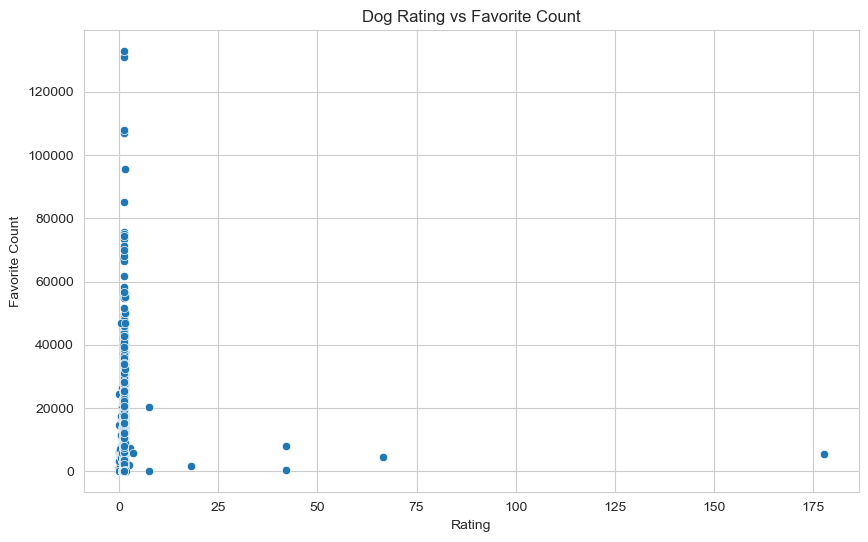

In [17]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=twitter_master, x='rating', y='favorite_count')
plt.title('Dog Rating vs Favorite Count')
plt.xlabel('Rating')
plt.ylabel('Favorite Count')
plt.show()


## Visualization 2: Dog Stage Distribution by Favorite Count
Data Used:
Columns: dog_stage, favorite_count

Visualization:
A box plot can help us visualize how favorite counts vary between different dog stages.

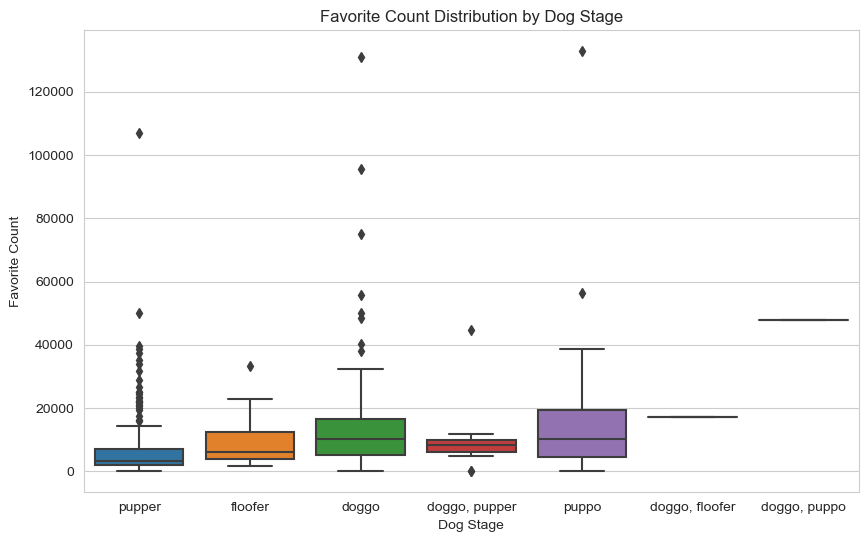

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(x='dog_stage', y='favorite_count', data=twitter_master)
plt.title('Favorite Count Distribution by Dog Stage')
plt.xlabel('Dog Stage')
plt.ylabel('Favorite Count')
plt.show()


## Visualization 3: Tweet Engagement (Favorites + Retweets) by Dog Stage
Data Used:
Columns: dog_stage, favorite_count, retweet_count

Visualization:
Let’s visualize the total engagement (favorites + retweets) for each dog stage.

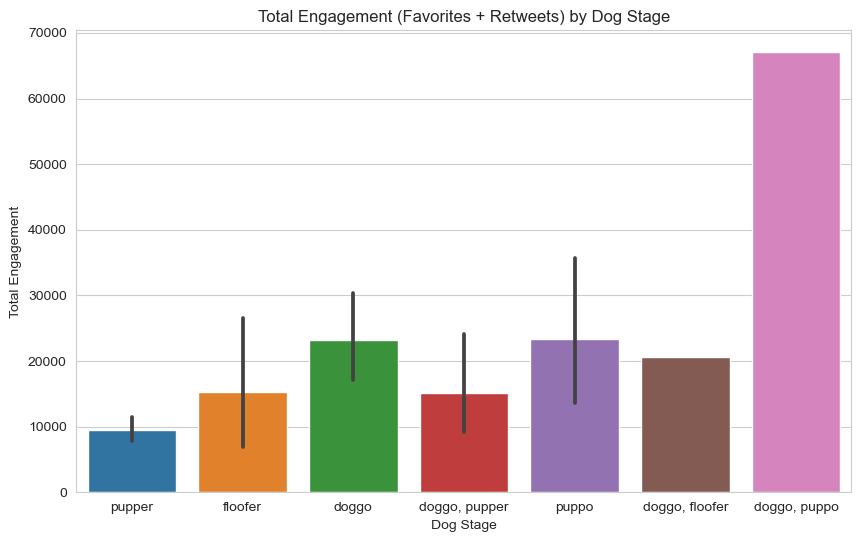

In [23]:
twitter_master['total_engagement'] = twitter_master['favorite_count'] + twitter_master['retweet_count']
plt.figure(figsize=(10,6))
sns.barplot(x='dog_stage', y='total_engagement', data=twitter_master)
plt.title('Total Engagement (Favorites + Retweets) by Dog Stage')
plt.xlabel('Dog Stage')
plt.ylabel('Total Engagement')
plt.show()


## Visualization 4: Frequency Bar Plot of Dog Stages
We'll visualize the frequency of each dog stage (e.g., doggo, pupper, etc.) using a bar plot.

Data Used:
Column: dog_stage

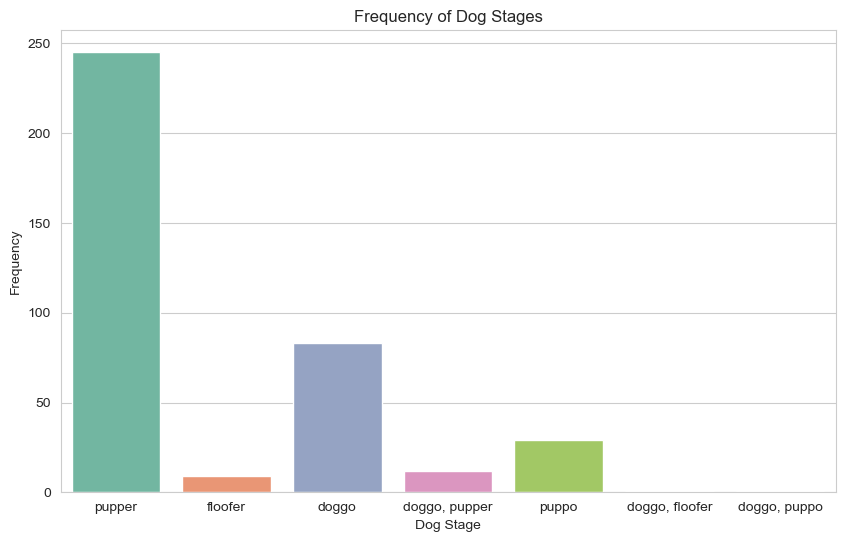

In [24]:
# Frequency bar plot of dog stages
plt.figure(figsize=(10,6))
sns.countplot(x='dog_stage', data=twitter_master, palette='Set2')
plt.title('Frequency of Dog Stages')
plt.xlabel('Dog Stage')
plt.ylabel('Frequency')
plt.show()


## Visualization 5: Pie Chart of Tweet Sources
This will show the distribution of tweet sources (such as iPhone, Twitter Web, etc.) using a pie chart.

Data Used:
Column: source

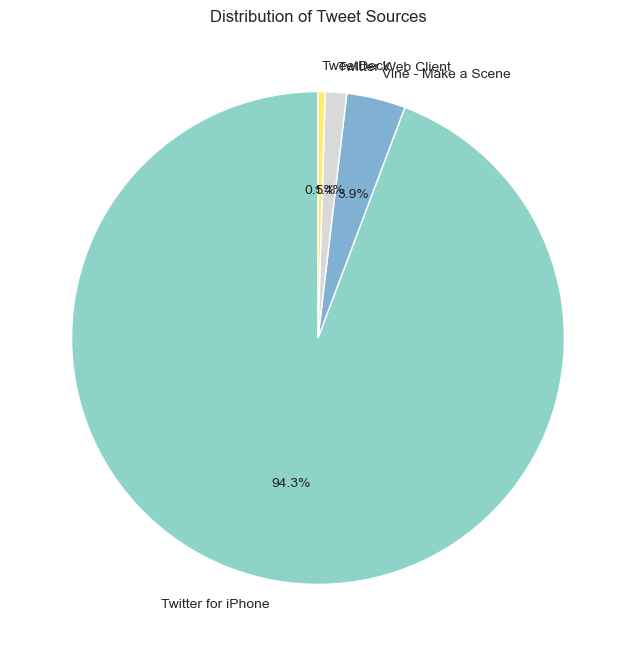

In [25]:
# Pie chart of tweet source distribution
source_counts = twitter_master['source'].value_counts()
plt.figure(figsize=(8,8))
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3', legend=False)
plt.title('Distribution of Tweet Sources')
plt.ylabel('')  # Hide the y-axis label for aesthetics
plt.show()
